In [11]:
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import re
from dx_utils import zetta
import glob

In [12]:
rootdir = os.getcwd()

# pat = r'canal_\d+\.\d+_\d+'
pat = r'\d+\.\d+'
path = rootdir+"/dtool_db/"
#print(path)
def get_data_directories(root_dir):
    data_dirs = []
    for root, dirs, files in os.walk(root_dir):
        if root.endswith('/data'):
            data_dirs.append(root)
    return data_dirs

datadir_list = get_data_directories(path)

In [13]:
datadir_list

['/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_650.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_750.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_500.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_850.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_0.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_0.0_562.5/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_600.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_800.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_550.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_900

[  0. 460. 480. 500. 520. 540. 560. 580.] [600.]
(8, 1)


/tmp/ipykernel_10400/1246398972.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.linspace(0,2,7).round(2) )


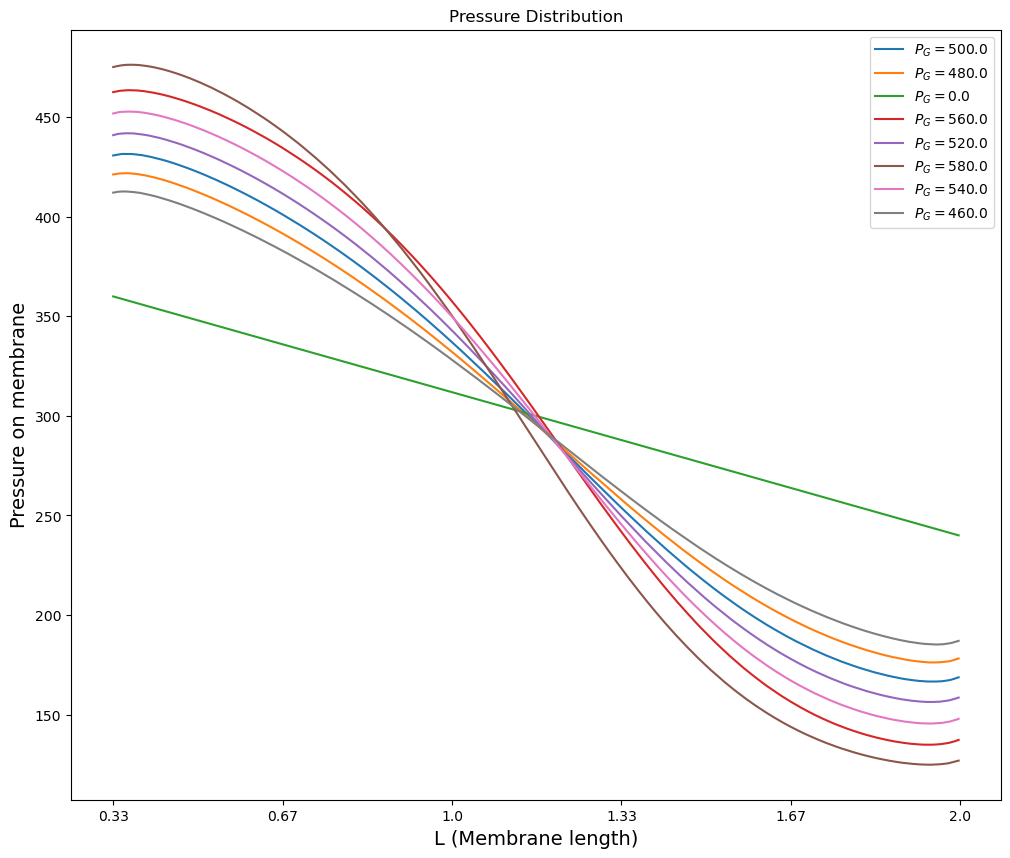

In [11]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue

        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        #print(u)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]

        ax.plot(u, label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.mean(u)
    print(radii, press)
    print(arr.shape)
    #neg = ax.plot(arr)
    #ax.contour(arr, colors='red')
    ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'Pressure on membrane', fontsize=14)
    ax.set_xlabel(r'L (Membrane length)', fontsize=14)
    return arr
    fig.savefig("press_dist.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/p_courve_0.32/p_courve.txt", "Pressure Distribution", yl='P delta', legend=True)

In [5]:
from dtoolcore import DataSet
import json

def get_height_from_dtool(dataset_uri):
    ## Dataset-level metadata
    dataset = DataSet.from_uri(dataset_uri)
    
    # Load the dataset
    dataset = DataSet.from_uri(dataset_uri)
    
    # Get the 'metadata' annotation
    metadata = dataset.get_annotation("metadata")
    
    # Print the metadata
    res = metadata[0]
    if res["p0"] == 0:
        return 0
    y = zetta(res["p0"], res["pl"], res["pg"],2,280, num=500)
    
    return np.min(y)


print(get_height_from_dtool("/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_540.0_560.0"))

p0:  336.0082686438839  pg:  540  pl:  224.00726581164102
0.5351327105934243


(0, 0)


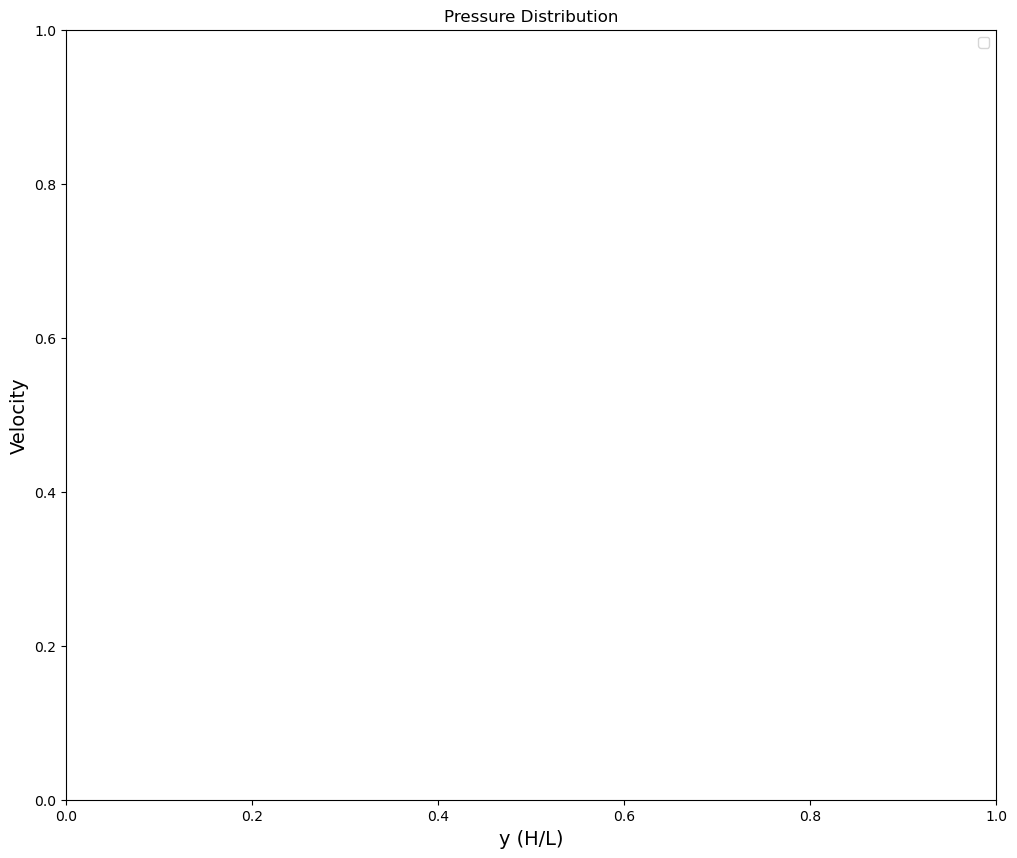

In [16]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def find_matching_files(directory, pattern):
    regex = re.compile(pattern)
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if regex.search(os.path.join(root, file)):
                matching_files.append(os.path.join(root, file))
    return matching_files

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    pg = "660.0"
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        
        min_index = np.argmin(np.abs(u[:,0]))
        rolled_back = np.roll(u[:,0], -min_index)
        
        h_max = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        ax.plot(rolled_back, label=rf"$P_G={extracted}$")
        #ax.plot(np.linspace(0,h_max,100),u[:,0], label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.max(u)
    print(arr.shape)

    ax.legend()
    ax.set_ylabel(r'Velocity', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)
    #return arr
    plt.show()
    #fig.savefig("velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/y_at_5_.*_0.32/y_at_5_.*.txt", "Pressure Distribution", yl='P delta', legend=True)

(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(8, 1)


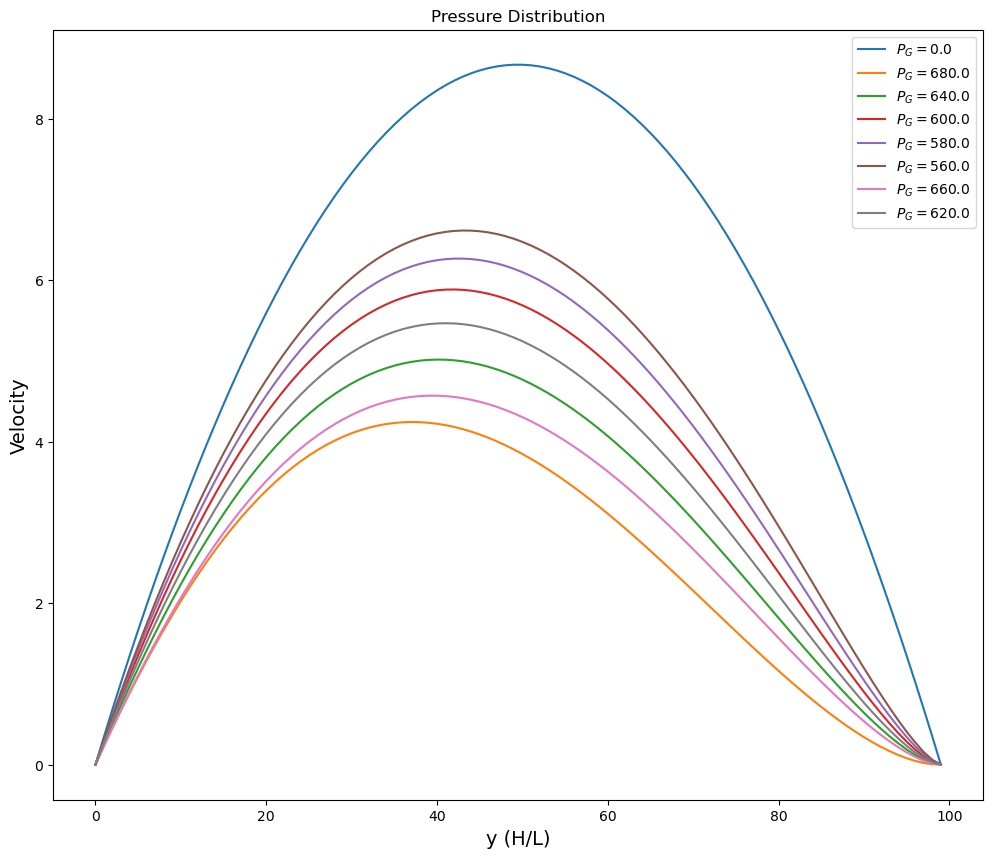

In [9]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'700\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'700\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        #print(u)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        print(u.shape)
        ax.plot(u[:,0], label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.max(u)
    #print(radii, press)
    print(arr.shape)
    #neg = ax.plot(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'Velocity', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)
    #return arr
    fig.savefig("velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/y_at_0_0.48/y_at_0.txt", "Pressure Distribution", yl='P delta', legend=True)

650.0 3.9799110851
750.0 3.823760247
500.0 4.1742599045
850.0 3.6440213273
0.0 4.391617668
600.0 4.0497193144
800.0 3.7369608045
550.0 4.1143154053
900.0 3.5441417009
950.0 3.4379636183
1000.0 3.3211752876
700.0 3.9049619778
(12, 1)


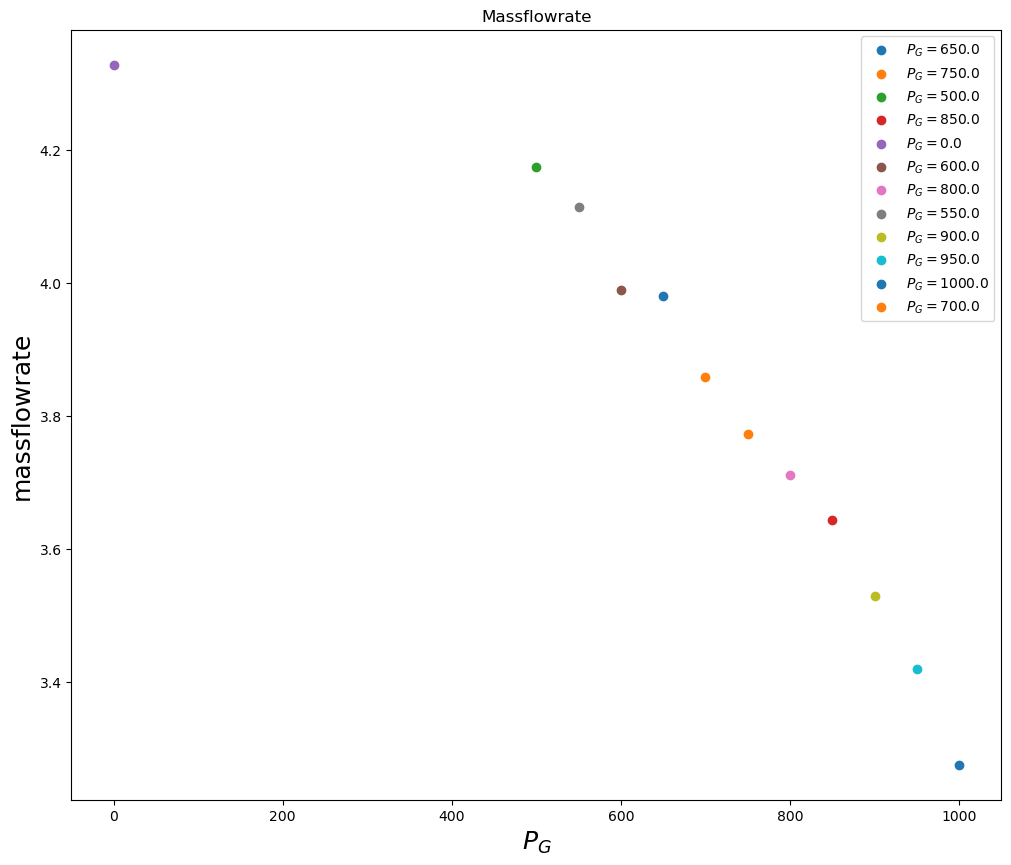

In [15]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'
import time

def plot_press1(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'550\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'550\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        time.sleep(.01)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        #r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        #print(u.shape)
        print(float(extracted), u[0])
        ax.scatter(float(extracted), u[1], label=rf"$P_G={extracted}$")
        #ax.plot(u)
        #arr[r_index, p_index] = u[0] # np.mean(u)
    
    #print(radii, press)
    print(arr.shape)
    #neg = ax.imshow(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'massflowrate', fontsize=18)
    ax.set_xlabel(r'$P_G$', fontsize=18)
    #return arr
    fig.savefig("fixed_mass_flow.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr2 = plot_press1(pat, pat2, "/flux_trapz_0.32/flux_trapz.txt", "Massflowrate", yl='P delta', legend=True)

In [81]:
print(arr)

[[ 6.94489500e-310  6.94489500e-310  4.64449359e-310  3.56266807e-001
   4.94065646e-324  4.94065646e-324]
 [-1.44010667e+304 -2.12561252e+304 -3.29167444e+304              nan
   2.18007543e-106              nan]
 [ 1.01077333e-274  1.23387897e-178              nan  3.95252517e-323
   7.29111892e-304  1.18168601e-125]
 [ 1.59451272e-202 -1.78272453e+304  6.94487147e-310  2.95034546e-001
   6.94487145e-310  4.64445799e-310]
 [ 6.94487147e-310  4.64445799e-310  6.94488128e-310  6.94485431e-310
   6.94488234e-310  6.94485302e-310]
 [ 6.94487146e-310  4.64445799e-310  6.94487146e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94487146e-310  0.00000000e+000  6.94487147e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94487147e-310  4.64445799e-310  6.94488122e-310  4.64445799e-310
   6.94487146e-310              nan]
 [ 6.94487146e-310  4.64445799e-310  6.94487146e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94488240e-310  6.94485432e-310  

(8, 1)


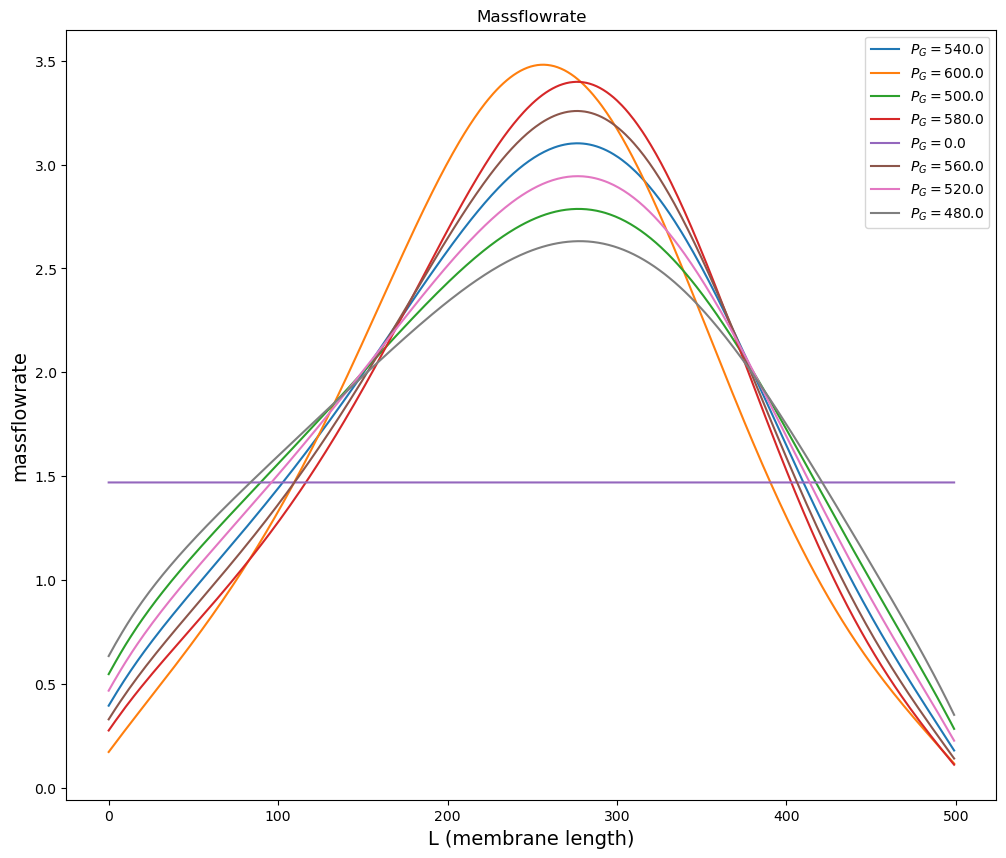

In [18]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'
import time

def plot_press2(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'620\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'620\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        time.sleep(.01)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        #r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        #print(u.shape)
        ax.plot(u[:,0], label=rf"$P_G={extracted}$")
        #arr[r_index, p_index] = u[0] # np.mean(u)
    
    #print(radii, press)
    print(arr.shape)
    #neg = ax.imshow(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'massflowrate', fontsize=14)
    ax.set_xlabel(r'L (membrane length)', fontsize=14)
    return arr
    #fig.savefig("press_dist.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr2 = plot_press2(pat, pat2, "/y_courve_0.64/y_courve.txt", "Massflowrate", yl='P delta', legend=True)